In [1]:
import math
import random

import time
import logging

from dataclasses import dataclass

import numpy as np
import scipy.stats

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
@dataclass
class Obstacle: 
    orientation: tuple # x, y, angle (angle of front face normal to axis)
    size: tuple # length , width
    faces: tuple # ID of face going counter clockwise from 'front' face

In [3]:
obs = [
    Obstacle((0.5, 0.5, 0.0), (0.1, 0.1), (1,0,0,0)),
    Obstacle((0.5, 1.5, math.pi/2), (0.1, 0.1), (1,0,0,0)),
    Obstacle((1.0, 1.5, 5*math.pi/4), (0.2, 0.1), (1,0,0,0)),
    ]

In [4]:
def rotationMatrix2d(angles): #Homogeneous
    N = len(angles)
    cT = np.cos(angles)
    sT = np.sin(angles)
    rotM = np.transpose(np.stack([
        [cT, -sT, np.zeros(N)],
        [sT, cT, np.zeros(N)],
        [np.zeros(N), np.zeros(N), np.ones(N)]
    ]), [2,0,1])
    return rotM

In [5]:
def forwardVector(angles):
    return np.transpose(np.array([[np.cos(angles)], [np.sin(angles)]]), [2,0,1])

In [6]:
class Map(object):
    def __init__(self, obstacles):
        self.obstacles = obstacles
        
        self.facesId = []
        self.facesFrame = []
        self.facesAngle = []
        
        self.facesVertex = []
        
        for o in obstacles:
            
            x,y,a = o.orientation
            l,w = o.size #length , width
            cA = math.cos(a)
            sA = math.sin(a)
            
            vertices = []
            vertices.append(np.array([[0,0,0,0], [-w/2, w/2, w/2, -w/2], [1.0, 1.0, 1.0, 1.0]]))
            vertices.append(np.array([[0,0,0,0], [-l/2, l/2, l/2, -l/2], [1.0, 1.0, 1.0, 1.0]]))
            vertices.append(np.array([[0,0,0,0], [-w/2, w/2, w/2, -w/2], [1.0, 1.0, 1.0, 1.0]]))
            vertices.append(np.array([[0,0,0,0], [-l/2, l/2, l/2, -l/2], [1.0, 1.0, 1.0, 1.0]]))
            vertices = np.stack(vertices, 0)
            
            facesAngle = np.fmod(np.array([0, math.pi/2, math.pi, 3*math.pi/2]) + a,2*math.pi)
            facesAngle[facesAngle >= math.pi/2] = facesAngle[facesAngle >= math.pi/2] - 2*math.pi
            
            ids = np.array(list(o.faces))
            base = rotationMatrix2d(facesAngle)
            
            origins = np.zeros((4,3,1), dtype=float)
            origins[:,2] = 1.0
            
            origins = np.matmul(np.array([
                [[1, 0, l/2],
                 [0, 1, 0],
                 [0, 0, 1]],
                [[1, 0, 0],
                 [0, 1, w/2],
                 [0, 0, 1]],
                [[1, 0, -l/2],
                 [0, 1, 0],
                 [0, 0, 1]],
                [[1, 0, 0],
                 [0, 1, -w/2],
                 [0, 0, 1]],
            ]), origins)
            
            origins = np.matmul(np.array([
                [cA, -sA, x],
                [sA, cA, y],
                [0.0, 0.0, 1.0]
            ]), origins)

            base[:,:2,2] = origins[:,:2,0]
            
            vertTransformed = np.matmul(base, vertices)
            vertTransformed[:,2] = [0.15, 0.15, 0.0, 0.0]
            
            self.facesId.append(ids)
            self.facesFrame.append(base)
            self.facesAngle.append(facesAngle)
            self.facesVertex.append(vertTransformed)
            
        self.facesId = np.concatenate(self.facesId)
        self.facesFrame = np.concatenate(self.facesFrame)
        self.facesAngle = np.concatenate(self.facesAngle)
        self.facesVertex = np.concatenate(self.facesVertex)
    
    def plotKeypoints(self, xlim=(0, 2.0), ylim=(0, 2.0), quiverScale=20):
        fig = plt.figure()
        
        #Points
        points = self.facesFrame[:, :2, 2]
        pointsLabels = self.facesId[:]
        plt.scatter(points[:,0], points[:,1])
        
        # x
        plt.quiver(points[:,0], points[:,1], self.facesFrame[:,0,0], self.facesFrame[:,1,0], color=[(1,0,0,1)], scale=quiverScale)
        
        # y
        plt.quiver(points[:,0], points[:,1], self.facesFrame[:,0,1], self.facesFrame[:,1,1], color=[(0,1,0,1)], scale=quiverScale)
        
        for i,faceId in enumerate(self.facesId):
            plt.annotate(faceId, (points[i,0], points[i,1]))
            
        plt.axis('equal')
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.gca().set_autoscale_on(False)
        plt.grid()
        
        
        return fig
    
    def getRelativePoints(self, detectId, detectOrientation):
        # detectOrientation = [x,y,angle] #angle is angle of normal of sign saw by camera
        
        detectMask = self.facesId == detectId
        
        relPoints = np.matmul(self.facesFrame[detectMask], np.array([[[detectOrientation[0]], [detectOrientation[1]], [1.0]]]))
        facing = self.facesAngle[detectMask].reshape(-1,1,1) - detectOrientation[2] + math.pi
        facing[facing >= math.pi] = facing[facing >= math.pi] - 2*math.pi
        
        return np.concatenate([relPoints[:,:2], facing], axis=1)
    
    def getProjection(self, pose, intrinsics, camHeight=0.12, epsilon=1e-6):
        # Project obstacle bounds 
        # pose = [1x3]
        direction = np.array([[math.cos(pose[0,2])], [math.sin(pose[0,2])]])
        r = self.facesFrame[:,:2,2] - pose[:,:2]
        dirCond = np.matmul(r, direction)
        dirCond[np.abs(dirCond) < epsilon] = 0
        normalCond = np.matmul(robotMap.facesFrame[:,:2,0], direction)
        normalCond[np.abs(normalCond) < epsilon] = 0.0
        mask = np.logical_and(dirCond > 0, normalCond < 0)
        verticies = robotMap.facesVertex[mask.ravel()]
        
        P = intrinsics
        
        up = np.array([0.0,0.0,1.0])
        front = np.array([direction[0,0], direction[1,0], 0.0])
        
        right = np.cross(front, up)#np.cross(up, front)#np.cross(front, up)
        camUp = np.cross(right, front)#np.cross(front, right)#np.cross(right, front)
        
        V = np.identity(4)
        V[0,:3] = right
        V[1,:3] = camUp
        V[2,:3] = front
        temp = np.identity(4)
        temp[:2, 3] = -pose[:,:2]
        temp[2, 3] = -camHeight
        V = np.matmul(V, temp)
        
        projectedVert = []
        worldV = []
        for i in range(len(verticies)):
            #print(verticies[i].shape)
            model = np.concatenate([verticies[i], [[1.0, 1.0, 1.0, 1.0]]], axis=0)
            world = np.matmul(V, model)
            worldV.append(world)
            projected = np.matmul(P, world)
            projectedVert.append(projected)
        return projectedVert, worldV, np.arange(len(mask))[mask.ravel()]
        

In [7]:
def plotPose(poses, color=(1,1,0,1)):
    # poses = [[[x],[y],[angle]], [[x],[y],[angle]]]
    
    plt.scatter(poses[:,0,0], poses[:,1,0], color=color)
    
    forVec = forwardVector(poses[:,2,0])
    #print(forVec.shape)
    
    plt.quiver(poses[:,0,0], poses[:,1,0], forVec[:,0,0], forVec[:,1,0], color=[color])
    

In [8]:
robotMap = Map(obs)

<IPython.core.display.Javascript object>


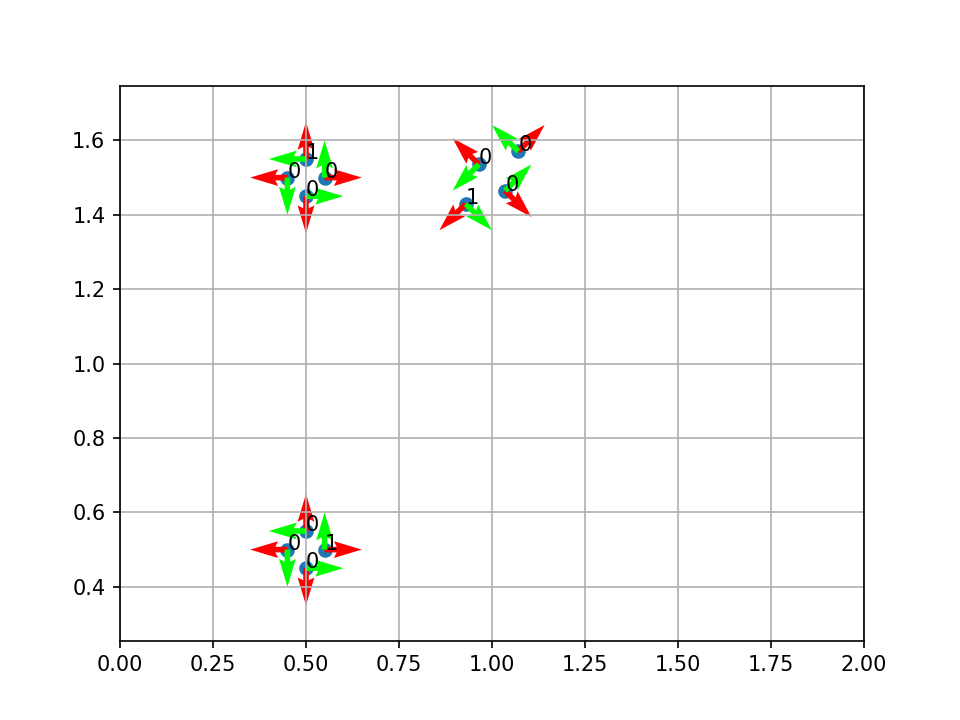

In [9]:
fig1 = robotMap.plotKeypoints(quiverScale=20)

In [10]:
robotMap.facesAngle

array([ 0.        , -4.71238898, -3.14159265, -1.57079633, -4.71238898,
       -3.14159265, -1.57079633,  0.        , -2.35619449, -0.78539816,
        0.78539816, -3.92699082])

<IPython.core.display.Javascript object>


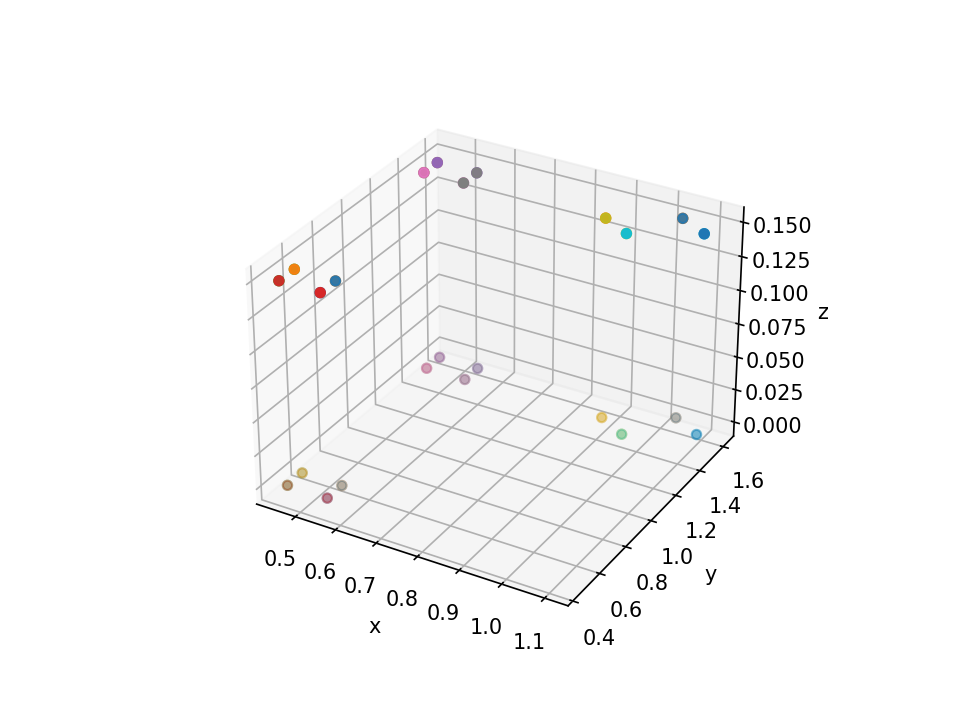

Text(0.5, 0, 'z')

In [11]:
fig2 = plt.figure()
ax = fig2.add_subplot(111, projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

In [12]:
robotMap.facesVertex.shape

(12, 3, 4)

In [13]:
for i in range(len(robotMap.facesVertex)):
    ax.scatter3D(robotMap.facesVertex[i,0,:], robotMap.facesVertex[i,1,:], robotMap.facesVertex[i,2,:])

In [14]:
relPoses = robotMap.getRelativePoints(0, [0.2, 0.0, 0.0])

In [15]:
relPoses

array([[[ 0.5       ],
        [ 0.75      ],
        [-1.57079633]],

       [[ 0.25      ],
        [ 0.5       ],
        [ 0.        ]],

       [[ 0.5       ],
        [ 0.25      ],
        [ 1.57079633]],

       [[ 0.25      ],
        [ 1.5       ],
        [ 0.        ]],

       [[ 0.5       ],
        [ 1.25      ],
        [ 1.57079633]],

       [[ 0.75      ],
        [ 1.5       ],
        [-3.14159265]],

       [[ 1.1767767 ],
        [ 1.3232233 ],
        [ 2.35619449]],

       [[ 1.21213203],
        [ 1.71213203],
        [-2.35619449]],

       [[ 0.8232233 ],
        [ 1.6767767 ],
        [-0.78539816]]])

<IPython.core.display.Javascript object>


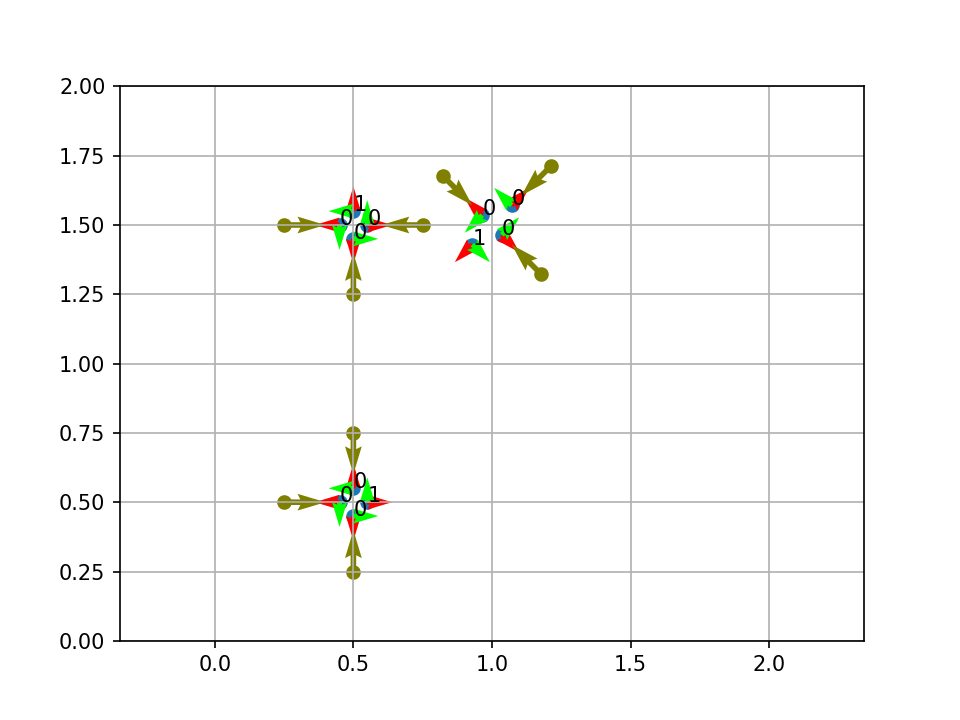

In [16]:
fig2 = robotMap.plotKeypoints(quiverScale=30)
plotPose(relPoses,color=(0.5,0.5,0,1))

In [17]:
relPoses2 = robotMap.getRelativePoints(0, [0.2, 0.1, math.pi/8])

<IPython.core.display.Javascript object>


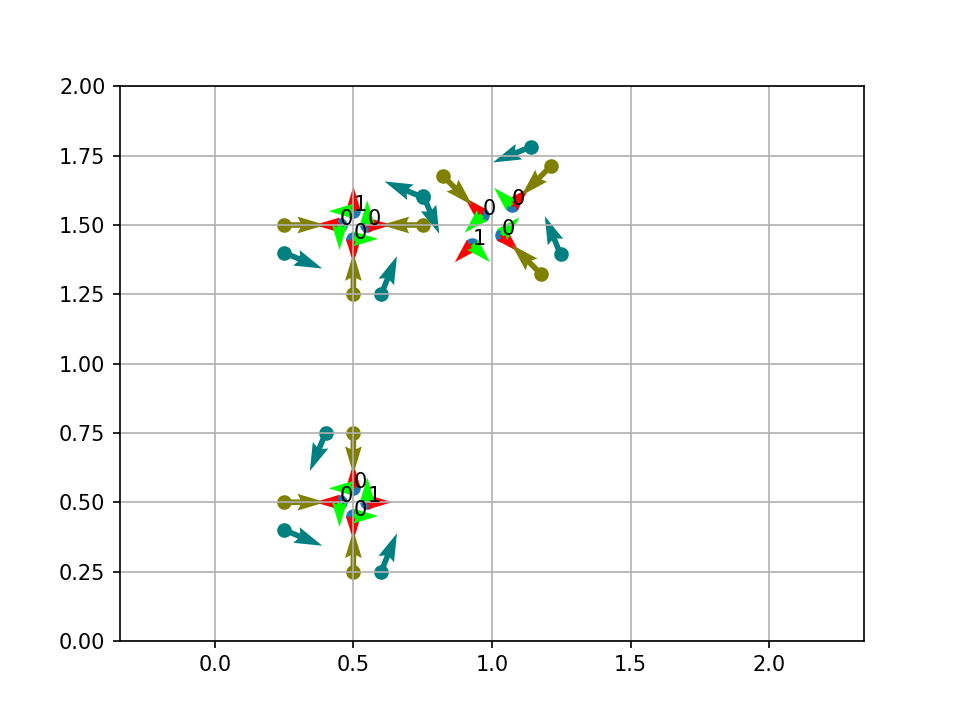

In [18]:
fig3 = robotMap.plotKeypoints(quiverScale=30)
plotPose(relPoses,color=(0.5,0.5,0,1))
plotPose(relPoses2,color=(0.0,0.5,0.5,1))

In [19]:
def relPoseNormPdf(relPoses, relPosesStd, orientations, resolution=np.array([[[0.0001],[0.0001],[0.01*math.pi/180]]])):
    # K Keypoints
    # P particles
    # relPoses = (K,3,1)
    # relPosesStd = (K,3,1)
    # orientations = (1,3,P)
    
    #print(relPoses.shape)
    #print(relPosesStd.shape)
    #print(orientations.shape)
    
    posDist = scipy.stats.norm(loc=relPoses[:,:2], scale=relPosesStd[:,:2])
    angleDist = scipy.stats.norm(loc=np.expand_dims(relPoses[:,2],-1), scale=np.expand_dims(relPosesStd[:,2],-1))
    
    angles = orientations[0,2,:] + np.array([[[2*math.pi],[0.0],[-2*math.pi]]])
    
    # Using cdf
    posProb = posDist.cdf(orientations[0,:2,:]+resolution[0,:2]/2) - posDist.cdf(orientations[0,:2,:]-resolution[0,:2]/2)
    angleProb = np.max(np.abs(angleDist.cdf(angles+resolution[0,2,0]/2) - angleDist.cdf(angles-resolution[0,2,0]/2)), axis=1)
    
    # Using pdf (probably wrong)
    # posProb = posDist.pdf(orientations[0,:2,:])
    # angleProb = np.max(angleDist.pdf(angles), axis=1)
    
    prob = np.concatenate([posProb, np.expand_dims(angleProb,1)], axis=1)
    return prob
    

In [20]:
relPoseNormPdf(relPoses, np.array([[[0.05], [0.05], [10*math.pi/180]]]), np.array([[[0.5,0.5],[0.75,0.25],[10*math.pi/180, -15*math.pi/180]]]))

array([[[7.97884428e-004, 7.97884428e-004],
        [7.97884428e-004, 1.53894512e-025],
        [6.44744130e-151, 3.33066907e-016]],

       [[2.97345093e-009, 2.97345093e-009],
        [2.97345093e-009, 2.97345092e-009],
        [2.41970725e-004, 1.29517602e-004]],

       [[7.97884428e-004, 7.97884428e-004],
        [0.00000000e+000, 7.97884428e-004],
        [5.05228435e-018, 4.57539642e-028]],

       [[2.97345093e-009, 2.97345093e-009],
        [1.10618321e-052, 1.53094515e-139],
        [2.41970725e-004, 1.29517602e-004]],

       [[7.97884428e-004, 7.97884428e-004],
        [1.53894512e-025, 1.10426310e-090],
        [5.05228435e-018, 4.57539642e-028]],

       [[2.97345092e-009, 2.97345092e-009],
        [1.10618321e-052, 1.53094515e-139],
        [7.00426618e-067, 1.07319479e-086]],

       [[1.31298566e-043, 1.31298566e-043],
        [2.29838493e-032, 7.19745368e-104],
        [4.69522573e-038, 5.53076117e-053]],

       [[7.12895459e-048, 7.12895459e-048],
        [3.1394650

In [21]:
def scaleDistribution(dist):
    return dist / np.sum(dist,0)

In [22]:
class ParticleFilter(object):

    def __init__(self, N, particles):
        self.N = N
        self.setParticles(particles)
        self.initWeight()
    
    def initWeight(self): 
        self.weights = np.ones(self.N)/N
    
    def setParticles(self, particles):
        self.particles = particles

    def resample(self): 
        index = np.random.choice(self.N, p=self.weights, size=self.N)
        self.particles = self.particles[:,index]
        self.initWeight()
        
    def neff(self):
        return 1.0/np.sum(np.power(self.weights,2))
    
    def chechAndResample(self, neffHigh):
        
        if(self.neff() < neffHigh):
            self.resample()
    
    def predict(self, movement, movementStd):
        # movement = [x, y, angle] relative to starting point of particle
        
        rotM = rotationMatrix2d(self.particles[2,:])
        self.particles += np.matmul(rotM, (np.random.normal(loc=movement, scale=movementStd)).ravel()).T
        
    def update(self, kpRelPoses, kpRelPosesStd, resolution=np.array([[[0.0001],[0.0001],[0.01*math.pi/180]]])):
        # len = number of symbols seen in image
        # kpRelPoses = [ relPoses0, relPoses1, ... ]
        # kpRelPosesStd = [ [xStd0, yStd0, angleStd0], [xStd1, yStd1, angleStd1] ]
        
        for i in range(len(kpRelPoses)):
            probs = relPoseNormPdf(kpRelPoses[i], kpRelPosesStd[i], np.expand_dims(self.particles,0), resolution=resolution)
            combinedProb = np.sum(probs, axis=0) / len(kpRelPoses[i])
            self.weights = np.multiply(self.weights, np.product(combinedProb, axis=0))
        
        self.weights = self.weights + 1e-300
        self.weights = self.weights / np.sum(self.weights)
        
    def getCurrentEstimate(self):
        return np.sum(np.multiply(self.weights, self.particles), axis=1)
        

In [23]:
def gaussianParticles(mean, std, N):
    return np.random.normal(mean, std, N)

In [24]:
N = 1000

In [25]:
x0 = np.array([[0.1],[0.1],[math.pi/2]])
x0Std = np.array([[0.05],[0.05],[2 * math.pi/180]])

In [26]:
pf = ParticleFilter(N, np.random.normal(x0, x0Std, (x0.shape[0],N)))

In [27]:
pf.particles.shape

(3, 1000)

In [28]:
def plotParticles(particles, xlim=[0,2], ylim=[0,2]):
    fig = plt.figure()
    plt.scatter(particles[0], particles[1])
    
    headingArrow = np.array([np.cos(particles[2]),np.sin(particles[2])])
    plt.quiver(particles[0], particles[1], headingArrow[0], headingArrow[1])
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    return fig

<IPython.core.display.Javascript object>


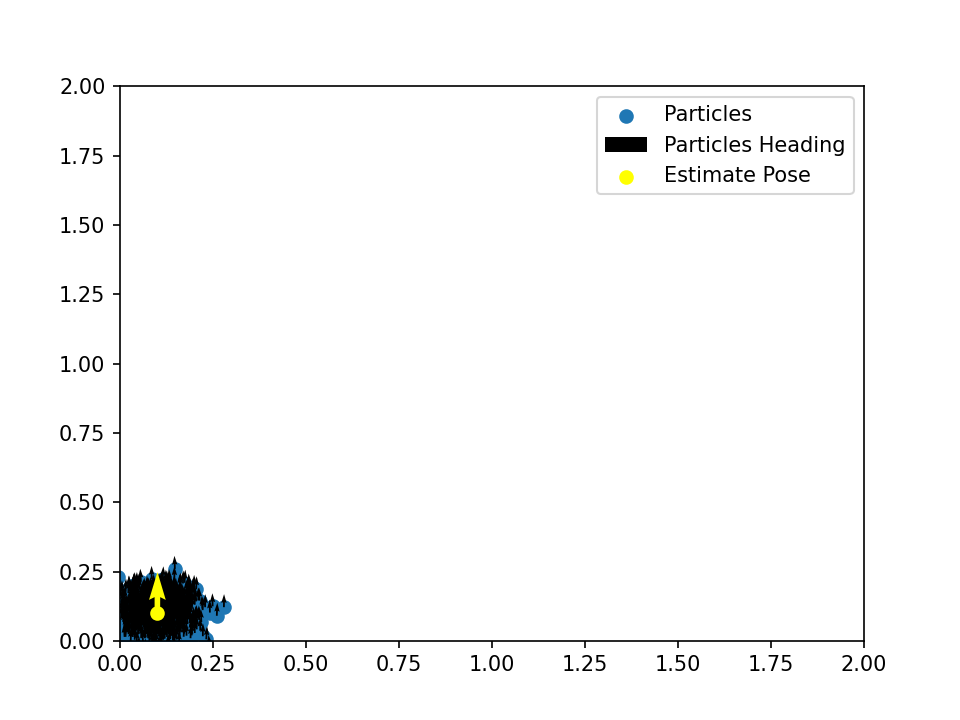

In [29]:
fig3 = plotParticles(pf.particles)
curEst = pf.getCurrentEstimate()
plotPose(np.expand_dims(np.expand_dims(curEst,0),-1))
plt.legend(["Particles", "Particles Heading", "Estimate Pose"])

In [30]:
#movement = np.array([[0.0], [0], [-math.pi/2]])
movement = np.array([[0.15], [0], [0.0]])

In [31]:
movementStd = np.array([[0.05],[0.05],[2*math.pi/180]])

In [32]:
rotM = pf.predict(movement,movementStd)

In [33]:
pf.particles

array([[0.07480971, 0.0581717 , 0.08914424, ..., 0.09357938, 0.07795502,
        0.06632241],
       [0.16692418, 0.23253157, 0.19599063, ..., 0.20014489, 0.2265202 ,
        0.18737271],
       [1.5829071 , 1.49414934, 1.58941351, ..., 1.56574941, 1.5770898 ,
        1.5208886 ]])

In [34]:
pf.update([relPoses], [np.array([[[0.05], [0.05], [10*math.pi/180]]])])

In [35]:
pf.getCurrentEstimate()

array([0.16798844, 0.24606031, 1.5830979 ])

In [36]:
np.max(pf.weights)*pf.N

37.97242893341437

In [37]:
pf.N

1000

In [38]:
pf.neff()

92.37979960701135

In [39]:
pf.chechAndResample(pf.N/2)

In [40]:
pf.weights.shape

(1000,)

In [41]:
pf.particles.shape

(3, 1000)

In [42]:
curEst = np.expand_dims(pf.getCurrentEstimate(),0)

In [43]:
curEst

array([[0.16754872, 0.24712786, 1.58460261]])

In [44]:
import pickle
calib_result_pickle = pickle.load(open("new_camera_calib_pickle.p", "rb" ))
mtx = calib_result_pickle["mtx"]
optimal_camera_matrix = calib_result_pickle["optimal_camera_matrix"]
dist = calib_result_pickle["dist"]
roi = calib_result_pickle["roi"]

In [45]:
roi

(4, 4, 630, 470)

In [46]:
optimal_camera_matrix

array([[479.70294189,   0.        , 316.37944574],
       [  0.        , 472.93228149, 237.7703312 ],
       [  0.        ,   0.        ,   1.        ]])

In [65]:
tVert,worldV,ind = robotMap.getProjection(np.array([[1.0, 1.0, (90+30)*math.pi/180]]), np.concatenate([optimal_camera_matrix, [[0],[0],[0]]], 1))
tVert = np.array(tVert)
worldV = np.array(worldV)
tVertN = np.divide(tVert, np.expand_dims(tVert[:,2,:],1))

In [66]:
tVert.shape

(4, 3, 4)

In [67]:
tVertN

array([[[135.01344841, 187.84342985, 187.84342985, 135.01344841],
        [259.11488429, 260.85102844, 145.44754224, 152.39211883],
        [  1.        ,   1.        ,   1.        ,   1.        ]],

       [[187.84342985, 237.91614193, 237.91614193, 187.84342985],
        [260.85102844, 258.00088272, 156.84812511, 145.44754224],
        [  1.        ,   1.        ,   1.        ,   1.        ]],

       [[464.33326365, 538.75996082, 538.75996082, 464.33326365],
        [268.92343737, 277.3093616 ,  79.61420959, 113.15790654],
        [  1.        ,   1.        ,   1.        ,   1.        ]],

       [[538.75996082, 736.42328921, 736.42328921, 538.75996082],
        [277.3093616 , 272.32470691,  99.55282837,  79.61420959],
        [  1.        ,   1.        ,   1.        ,   1.        ]]])

<IPython.core.display.Javascript object>


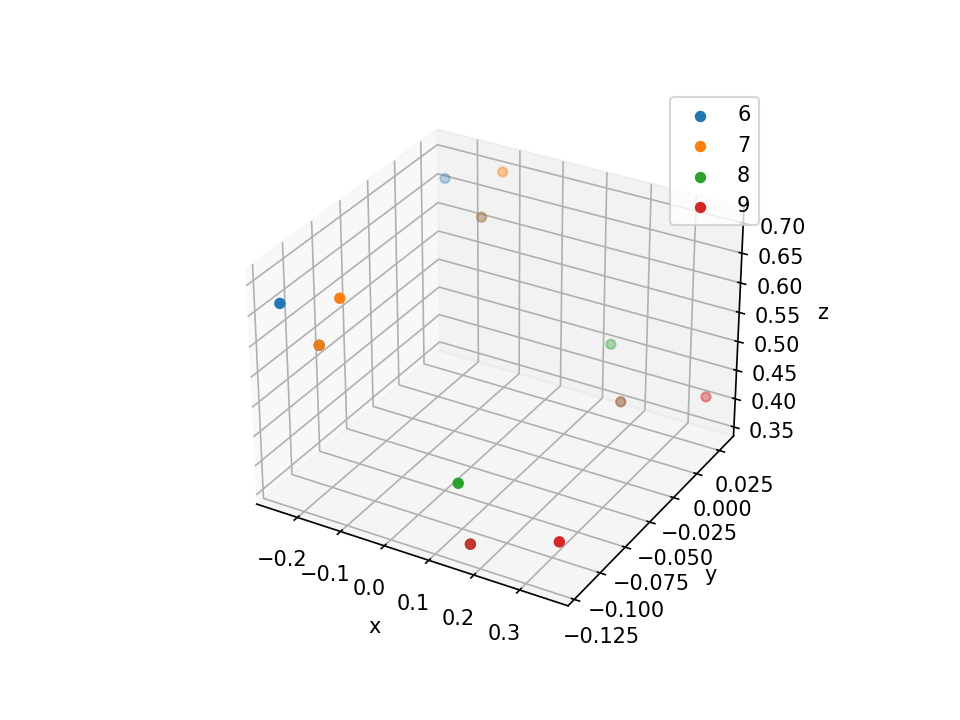

Text(0.5, 0, 'z')

In [68]:
fig4 = plt.figure()
ax4 = fig4.add_subplot(111, projection='3d')
ax4.set_xlabel("x")
ax4.set_ylabel("y")
ax4.set_zlabel("z")

In [70]:
worldV

array([[[-0.25131397, -0.16471143, -0.16471143, -0.25131397],
        [ 0.03      ,  0.03      , -0.12      , -0.12      ],
        [ 0.66471143,  0.61471143,  0.61471143,  0.66471143],
        [ 1.        ,  1.        ,  1.        ,  1.        ]],

       [[-0.16471143, -0.11471143, -0.11471143, -0.16471143],
        [ 0.03      ,  0.03      , -0.12      , -0.12      ],
        [ 0.61471143,  0.70131397,  0.70131397,  0.61471143],
        [ 1.        ,  1.        ,  1.        ,  1.        ]],

       [[ 0.14046647,  0.16634837,  0.16634837,  0.14046647],
        [ 0.03      ,  0.03      , -0.12      , -0.12      ],
        [ 0.45542709,  0.35883451,  0.35883451,  0.45542709],
        [ 1.        ,  1.        ,  1.        ,  1.        ]],

       [[ 0.16634837,  0.35953353,  0.35953353,  0.16634837],
        [ 0.03      ,  0.03      , -0.12      , -0.12      ],
        [ 0.35883451,  0.41059832,  0.41059832,  0.35883451],
        [ 1.        ,  1.        ,  1.        ,  1.        ]]])

In [71]:
for i in range(len(worldV)):
    ax4.scatter3D(worldV[i,0,:], worldV[i,1,:], worldV[i,2,:])
plt.legend(ind)

<IPython.core.display.Javascript object>


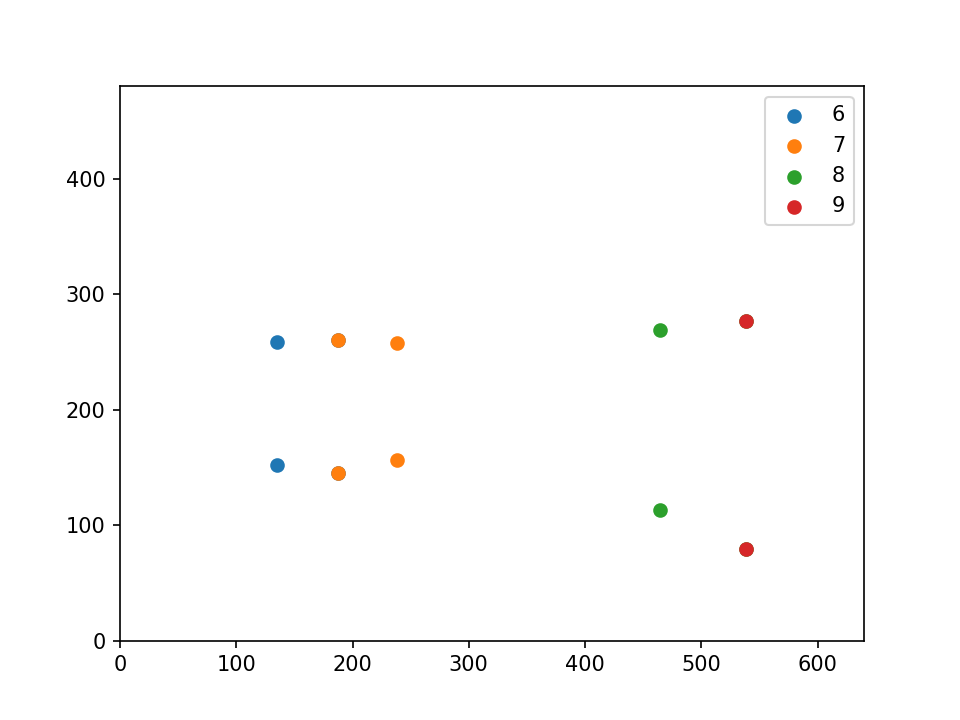

In [73]:
fig5 = plt.figure()
for i in range(len(tVertN)):
    plt.scatter(tVertN[i,0,:], tVertN[i,1,:])
plt.xlim([0,640])
plt.ylim([0,480])
plt.legend(ind)

In [74]:
tVert,worldV,ind = robotMap.getProjection(np.array([[0.5, 0.0, -90.0*math.pi/180]]), np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]]))
tVert = np.array(tVert)
worldV = np.array(worldV)
#tVertN = np.divide(tVert, np.expand_dims(tVert[:,2,:],1))